In [1]:
import os
import sys

import json
import pickle

import scipy
import seaborn as sns

import numpy as np
import pandas as pd
from dtw import dtw
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import dcor

In [2]:
data_training = pd.read_csv("../data/data_training.csv")
data_validation = pd.read_csv('../data/data_validation.csv')

data = pd.concat([data_training, data_validation])
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index('Date')
meta = pd.read_csv("../data/meta.csv")
data.index

DatetimeIndex(['1950-12-31', '1951-01-01', '1951-01-02', '1951-01-03',
               '1951-01-04', '1951-01-05', '1951-01-06', '1951-01-07',
               '1951-01-08', '1951-01-09',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=25568, freq=None)

In [3]:
def pearson(dx, dy):
    return scipy.stats.pearsonr(dx,dy)

def spearman(dx,dy):
    return scipy.stats.spearmanr(dx,dy)

def distance_correlation(dx,dy):
    return dcor.distance_correlation(dx, dy),0

def timewarping(dx,dy):
    distance, cost_matrix, acc_cost, path = dtw(np.array(dx).reshape(-1,1),np.array(dy).reshape(-1,1), dist = scipy.spatial.distance.euclidean)
    return distance



def corr(df,starting_point,interval,method,l,pv,p1):
    period2 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]

    for col in df.columns.tolist():
        cor, p_value = method(p1['2275'],period2[col])
        l.append(cor)
        pv.append(p_value)



def calculate_correlations(df,starting_point,interval,method):

    day = pd.Timedelta(1,'d')
    sp = starting_point
    l = []
    pv = []

    period1 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]
    for i in np.linspace(0,5,5):
        starting_point = starting_point + day
        corr(df,starting_point,interval,method,l,pv,period1)
    starting_point =  sp + day
    for i in np.linspace(0,50,50):
        starting_point = starting_point - day
        corr(df,starting_point,interval,method,l,pv,period1)

    cm = np.transpose(np.reshape(np.array(l), (-1, len(df.columns))))
    pv = np.transpose(np.reshape(np.array(pv), (-1, len(df.columns))))

    return cm, pv


correlation_matrix, p_values = calculate_correlations(data,pd.Timestamp('2006-01-01'),pd.Timedelta(52,'w'),pearson)

cr = pd.DataFrame(data = np.transpose(correlation_matrix), columns=data.columns)
cr.idxmax() - 5

1515       6
1516       5
1518       4
1521       5
1719       9
1720      14
1722       3
1723       3
2040       2
2046       1
2048       0
2271       0
2272       0
2274       0
2275       0
2278       2
2543       2
2753       5
2756       4
2757       2
2760       1
1514       5
2041      -1
1523       6
2042       2
2736       8
1721       3
1724       4
1725       4
2744       8
2748      10
2759       2
1520       4
1527       5
1729       4
1726       6
2541       3
1530       7
1732       5
1734       5
2049       5
2741       4
2742       6
2751       6
2545       5
744624     2
210888     0
210900     0
dtype: int64

In [44]:
max_corr = pd.Series((cr.idxmax() - 5),name="maximum_correlation")
max_corr.index = max_corr.index.astype(int)

In [45]:
meta = pd.read_csv("../data/meta.csv")
meta = meta.set_index("reg_number")

meta_nans_removed = meta.loc[list(map(int,cr.columns.tolist()))]
meta_nans_removed = pd.concat([meta_nans_removed, max_corr], axis=1)
meta.river.unique()


array(['Tisza', 'Maros', 'Kettős-Körös', 'Hármas-Körös', 'Szamos',
       'Sebes-Körös', 'Bodrog', 'Fekete-Körös', 'Fehér-Körös', 'Túr',
       'Sajó', 'Kraszna', 'Hernád', 'Zagyva', 'Berettyó'], dtype=object)

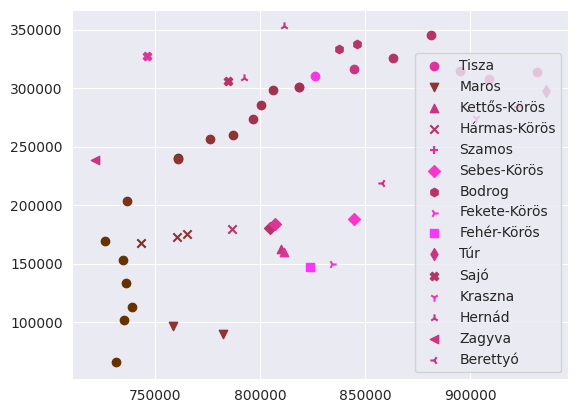

In [50]:
marker_dict = {
    'Tisza': 'o',
    'Maros': 'v',
    'Kettős-Körös': '^',
    'Hármas-Körös': 'x',
    'Szamos': '+',
    'Sebes-Körös' : 'D',
    'Bodrog' : 'h',
    'Túr' : 'd',
    'Sajó' : 'X',
    'Kraszna' : '1',
    'Hernád' : '2',
    'Berettyó': '3',
    'Fekete-Körös' : '4',
    'Fehér-Körös': ',',
    'Zagyva': '<'
}

def rgb(val):
    return [[0.4 + min(val * 0.08,0.6),0.2, 0.00 + min(abs(val * 0.10),1.0)]]

rivers = []
actors = []

for index,row in meta_nans_removed.iterrows():
    a = plt.scatter(row['EOVx'],row['EOVy'],c=rgb(row['maximum_correlation']),marker=marker_dict[row['river']])
    if row['river'] not in rivers:
        rivers.append(row['river'])
        actors.append(a)
plt.legend(actors,rivers)
plt.show()

In [42]:
from statsmodels.tsa.stattools import grangercausalitytests
def causality_test(df, lag,l,pv):

    for col in df.columns.tolist():
        vals = grangercausalitytests(data_nans_removed[['2275',col]], maxlag = [lag],verbose = 0)
        l.append(vals[lag][0]['ssr_ftest'][0])
        pv.append(vals[lag][0]['ssr_ftest'][1])


causalities = []
p_values = []
for i in np.linspace(1,10,10):
    causality_test(data_nans_removed,i,causalities,p_values)

causalitiy_matrix = np.transpose(np.reshape(np.array(causalities), (-1, len(data_nans_removed.columns))))

NameError: name 'data_nans_removed' is not defined

In [10]:
maximum_correlation = (cr.idxmax() - 5)

In [18]:
pd.DataFrame(maximum_correlation.values, index=maximum_correlation.index).to_csv("../data/maximum_correlation.csv")

In [14]:
maximum_correlation.values

array([ 6,  5,  4,  5,  9, 14,  3,  3,  2,  1,  0,  0,  0,  0,  0,  2,  2,
        5,  4,  2,  1,  5, -1,  6,  2,  8,  3,  4,  4,  8, 10,  2,  4,  5,
        4,  6,  3,  7,  5,  5,  5,  4,  6,  6,  5,  2,  0,  0])